In [4]:
import xarray as xr
from rasterio.enums import Resampling
import rasterio
import matplotlib.pyplot as plt
import numpy as np


In [9]:
# data_path = "/Users/fquareng/data/T_2M.nc"
# data_path = "/Users/fquareng/data/1h_2D/lffd20101117110000.nz"
# data_path = "/Users/fquareng/data/lffd20940101000000c.nc"
data_path = "/Users/fquareng/data/1h_2D_sel_blurred/lffd20101218210000_blurred.nz"


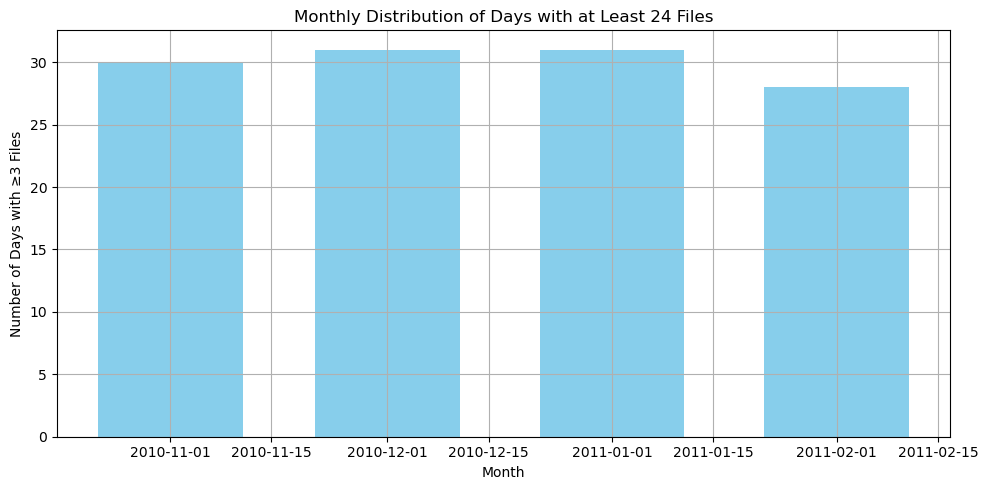

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Replace with your directory path
directory_path = "/Users/fquareng/data/1h_2D_sel"

# List all files in the directory
filenames = [f for f in os.listdir(directory_path) if f.endswith(".nz")]

# Step 1: Extract dates from filenames
dates = [datetime.strptime(f[4:12], "%Y%m%d").date() for f in filenames]

# Step 2: Count occurrences of each date
date_counts = pd.Series(dates).value_counts()

# Step 3: Filter dates with at least 3 files
days_with_min_files = date_counts[date_counts >= 24]

# Step 4: Group data by month
# Convert dates to the first day of their respective month
months = days_with_min_files.index.to_series().apply(lambda x: x.replace(day=1))
monthly_counts = days_with_min_files.groupby(months).count()

# Step 5: Create a plot
plt.figure(figsize=(10, 5))
plt.bar(monthly_counts.index, monthly_counts.values, color='skyblue', width=20)
plt.xlabel("Month")
plt.ylabel("Number of Days with ≥3 Files")
plt.title("Monthly Distribution of Days with at Least 24 Files")
# plt.xticks(rotation=45, labels=[m.strftime("%Y-%m") for m in monthly_counts.index])
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
directory_path = "/Users/fquareng/data/1h_2D_sel"

# List all files in the directory
filenames = [f for f in os.listdir(directory_path) if f.endswith(".nz")]



ds = xr.open_dataset(os.path.join(directory_path, filenames[-1]), engine="netcdf4")

In [19]:
ds

<xarray.Dataset> Size: 48MB
Dimensions:     (time: 1, rlat: 1542, rlon: 1542)
Coordinates:
  * time        (time) datetime64[ns] 8B 2011-01-26T09:00:00
  * rlon        (rlon) float32 6kB -18.86 -18.84 -18.82 ... 11.92 11.94 11.96
  * rlat        (rlat) float32 6kB -14.86 -14.84 -14.82 ... 15.92 15.94 15.96
    lon         (rlat, rlon) float32 10MB ...
    lat         (rlat, rlon) float32 10MB ...
    height_2m   float32 4B ...
    height_10m  float32 4B ...
    height_toa  float32 4B ...
Data variables:
    RELHUM_2M   (time, rlat, rlon) float32 10MB ...
    T_2M        (time, rlat, rlon) float32 10MB ...
    PS          (time, rlat, rlon) float32 10MB ...
Attributes:
    title:           COSMO driven by 4 km COSMO
    source:          COSMO_5.08
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org/
    creation_date:   2023-06-03 04:56:23
    history:         Fri May 24 19:49:28 2024: ncks -4 -L 6 --no_abc -O /proj...
    NCO:             netCDF Operators version 5.0.4 (Homepage = http://nco.sf...

In [23]:
print(ds.lon.min().values, ds.lat.min().values, ds.lon.max().values, ds.lat.max().values)

-26.539766 29.606312 34.34347 62.960003


In [9]:
data_path_b = "/Users/fquareng/data/1h_2D_sel_blurred/lffd20101218220000_blurred.nz"
data_path = "/Users/fquareng/data/1h_2D_sel/lffd20101218220000.nz"

ds = xr.open_dataset(data_path_b, engine="netcdf4")

T_2M = ds.T_2M.sel(time="2010-12-18T22:00:00")

plt.figure(figsize=(10, 6))
plt.pcolormesh(ds.rlon, ds.rlat, T_2M, cmap='coolwarm', shading='auto')
plt.colorbar(label='2m Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('2010-11-17T11:00:00')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/fquareng/data/1h_2D_sel_blurred/lffd20101218220000_blurred.nz'

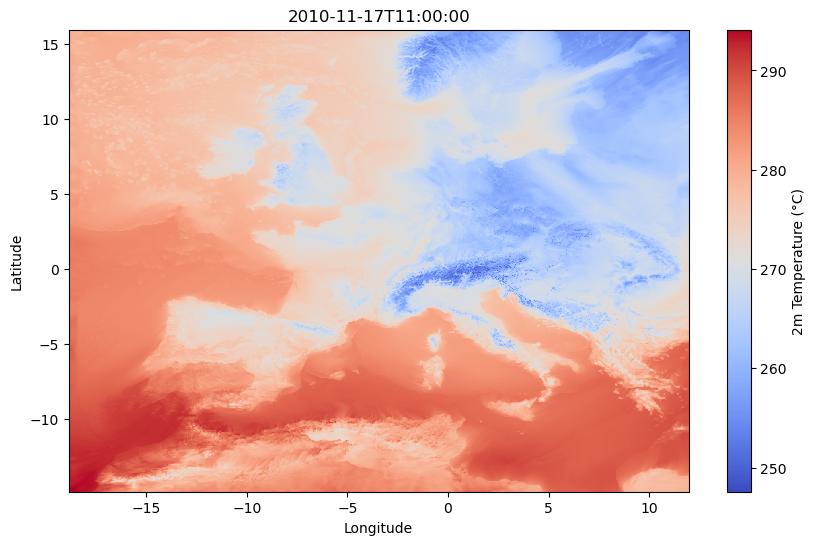

In [10]:
data_path_b = "/Users/fquareng/data/1h_2D_sel_blurred/lffd20101218220000_blurred.nz"
data_path = "/Users/fquareng/data/1h_2D_sel/lffd20101218220000.nz"

ds = xr.open_dataset(data_path, engine="netcdf4")

T_2M = ds.T_2M.sel(time="2010-12-18T22:00:00")

plt.figure(figsize=(10, 6))
plt.pcolormesh(ds.rlon, ds.rlat, T_2M, cmap='coolwarm', shading='auto')
plt.colorbar(label='2m Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('2010-11-17T11:00:00')
plt.show()

In [8]:
def stitch_tiffs(input_files, output_file):
    # Open the input TIFF files using rasterio
    with rasterio.open(input_files[0]) as src:
        # Get metadata of the first file
        meta = src.meta
        # Read the first file's data
        data = src.read(1)  # Assuming single-band files; adjust if more bands are present
        
    # Loop through the remaining TIFF files and append their data
    for file in input_files[1:]:
        with rasterio.open(file) as src:
            # Read data from current TIFF file
            new_data = src.read(1)  # Assuming single-band files; adjust if more bands are present
            
            # Combine the data along the appropriate axis
            data = np.hstack((data, new_data))  # For horizontal stitching (side by side)
            # data = np.vstack((data, new_data))  # For vertical stitching (one on top of another)

    # Update the metadata for the output file (e.g., width, height, etc.)
    meta.update({
        'count': 1,  # Number of bands (adjust if you have more than 1 band)
        'height': data.shape[0],
        'width': data.shape[1]
    })

    # Write the stitched data to the output TIFF file
    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(data, 1)  # Write to the first band (since we have single-band data)

    print(f"Stitched TIFF saved as: {output_file}")

# Example usage
input_files = [
    #'/Users/fquareng/data/DEM/output_hh 2.tif',
    '/Users/fquareng/data/DEM/output_hh 3.tif',
    '/Users/fquareng/data/DEM/output_hh 4.tif',
    '/Users/fquareng/data/DEM/output_hh 5.tif',
    '/Users/fquareng/data/DEM/output_hh 6.tif',

    # '/Users/fquareng/data/usgs_gmted2010_30arcsec_mean_stat_yVaz5oxWAM3AUVDdMByh.tiff',
]

output_file = '/Users/fquareng/data/DEM/europe_dem.tif'  # Path to save the new stitched TIFF

stitch_tiffs(input_files, output_file)

Stitched TIFF saved as: /Users/fquareng/data/DEM/europe_dem.tif


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 54412, 'height': 40024, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0008333333333333334, 0.0, -11.000416699999988,
       0.0, -0.0008333333333333334, 62.960416699999996)}


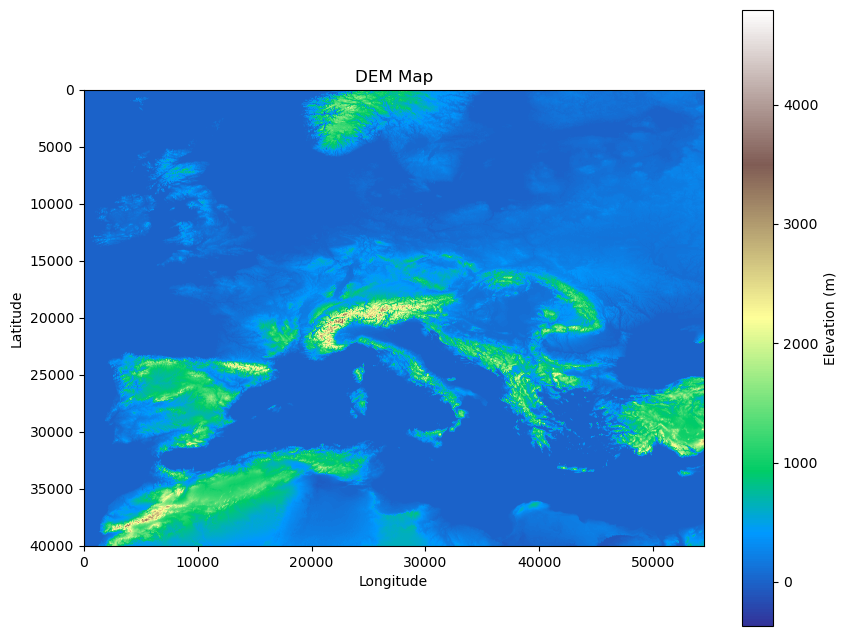

In [9]:
# Open the .tiff file using rasterio
dem_file = '/Users/fquareng/data/DEM/europe_dem.tif'
with rasterio.open(dem_file) as src:
    # Read the DEM data
    dem_data = src.read(1)  # Read the first band (assuming the DEM is single-band)

    # Get the metadata for the .tiff
    meta = src.meta
    print(meta)

# Plot the DEM data
plt.figure(figsize=(10, 8))
plt.imshow(dem_data, cmap='terrain', origin='upper')  # 'terrain' colormap for elevation
plt.colorbar(label='Elevation (m)')
plt.title('DEM Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [7]:
def downscale_tiff(input_file, output_file, new_lat, new_lon):
    with rasterio.open(input_file) as src:
        # Read original data and metadata
        data = src.read(1)  # Read the first band (adjust if there are multiple bands)
        transform = src.transform

        # Calculate new resolution based on new_lat and new_lon
        new_height = new_lat
        new_width = new_lon

        # Define the scale factors
        scale_factor_x = src.width / new_width
        scale_factor_y = src.height / new_height

        # Resample data using rasterio's built-in resampling
        resampled_data = src.read(
            out_shape=(src.count, new_height, new_width),  # Adjust dimensions
            resampling=Resampling.bilinear  # Choose the resampling method
        )

        # Update the transform for the new resolution
        new_transform = src.transform * src.transform.scale(
            (src.width / new_width),
            (src.height / new_height)
        )

        # Update metadata for the output file
        new_meta = src.meta.copy()
        new_meta.update({
            "height": new_height,
            "width": new_width,
            "transform": new_transform
        })

        # Write the downscaled data to a new TIFF file
        with rasterio.open(output_file, "w", **new_meta) as dst:
            dst.write(resampled_data)

    print(f"Downscaled TIFF saved as: {output_file}")

# Example usage
input_file = '/Users/fquareng/data/DEM/europe_dem.tif'  # Replace with your file path
output_file = '/Users/fquareng/data/DEM/europe_dem_low_res.tif'  # Path for the output file
new_lat = 1542  # Number of points in latitude (height)
new_lon = 1542  # Number of points in longitude (width)

downscale_tiff(input_file, output_file, new_lat, new_lon)

Downscaled TIFF saved as: /Users/fquareng/data/DEM/europe_dem_low_res.tif


In [8]:

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_and_resample_to_rotated_grid(input_file, output_file, new_pole, target_resolution):
    """
    Reproject and resample a DEM to a rotated grid with the specified new pole location.
    
    Args:
    - input_file: Path to the input DEM file.
    - output_file: Path to the output file.
    - new_pole: Tuple (latitude, longitude) for the new north pole.
    - target_resolution: Target resolution for the output DEM.
    """
    new_pole_lat, new_pole_lon = new_pole

    # Define rotated grid projection in Proj4 format
    rotated_pole_proj = (
        f"+proj=ob_tran +o_proj=longlat +o_lat_p={new_pole_lat} "
        f"+o_lon_p={new_pole_lon} +datum=WGS84"
    )

    with rasterio.open(input_file) as src:
        # Calculate the transformation for the new grid
        transform, width, height = calculate_default_transform(
            src.crs,
            rotated_pole_proj,
            src.width,
            src.height,
            *src.bounds,
            resolution=target_resolution,
        )

        # Update metadata for the new file
        profile = src.profile.copy()
        profile.update(
            {
                "crs": rotated_pole_proj,
                "transform": transform,
                "width": width,
                "height": height,
                "dtype": "float32",  # Set data type for consistency
            }
        )

        # Perform reprojection and resampling
        with rasterio.open(output_file, "w", **profile) as dst:
            for i in range(1, src.count + 1):  # Iterate through bands
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=rotated_pole_proj,
                    resampling=Resampling.bilinear,  # Use bilinear interpolation
                )

# Example usage
input_dem = '/Users/fquareng/data/DEM/europe_dem.tif'
output_dem = '/Users/fquareng/data/DEM/europe_dem_low_res_rotated.tif'
new_pole_coords = (43, -170)  # New north pole: lat=43, lon=-170
target_resolution = 0.05  # Set target resolution in degrees (adjust as needed)

reproject_and_resample_to_rotated_grid(input_dem, output_dem, new_pole_coords, target_resolution)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 799, 'height': 737, 'count': 1, 'crs': CRS.from_wkt('GEOGCRS["unnamed",BASEGEOGCRS["unknown",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ID["EPSG",6326]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],DERIVINGCONVERSION["unknown",METHOD["PROJ ob_tran o_proj=longlat"],PARAMETER["o_lat_p",43,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["o_lon_p",-170,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]],CS[ellipsoidal,2],AXIS["longitude",east,ORDER[1],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],AXIS["latitude",north,ORDER[2],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]]'), 'transform': Affine(0.05, 0.0, -179.97397820969286,
       0.0, -0.05, 19.44683637732141)}


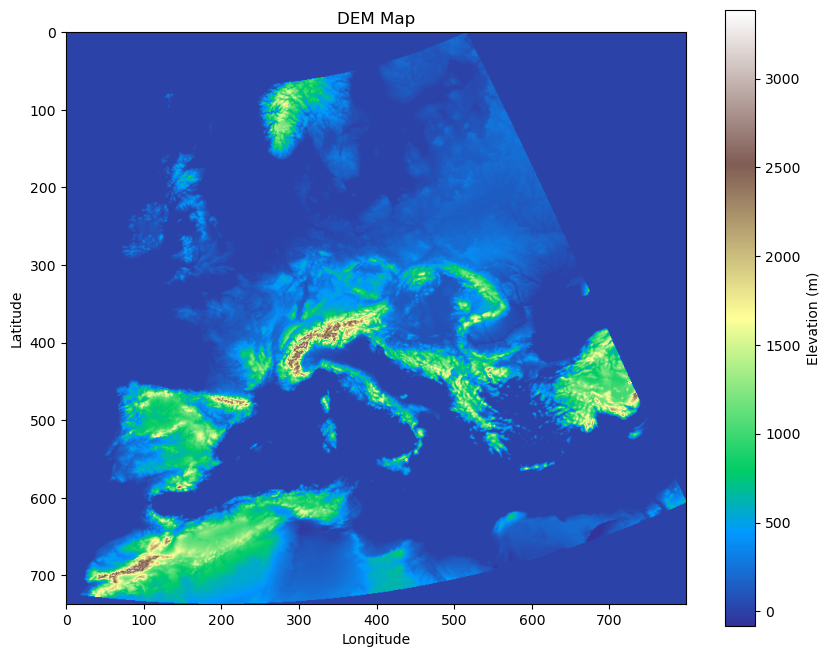

In [9]:

# Open the .tiff file using rasterio
dem_file = '/Users/fquareng/data/DEM/europe_dem_low_res_rotated.tif'
with rasterio.open(dem_file) as src:
    # Read the DEM data
    dem_data = src.read(1)  # Read the first band (assuming the DEM is single-band)

    # Get the metadata for the .tiff
    meta = src.meta
    print(meta)

# Plot the DEM data
plt.figure(figsize=(10, 8))
plt.imshow(dem_data, cmap='terrain')#, origin='upper')  # 'terrain' colormap for elevation
plt.colorbar(label='Elevation (m)')
plt.title('DEM Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

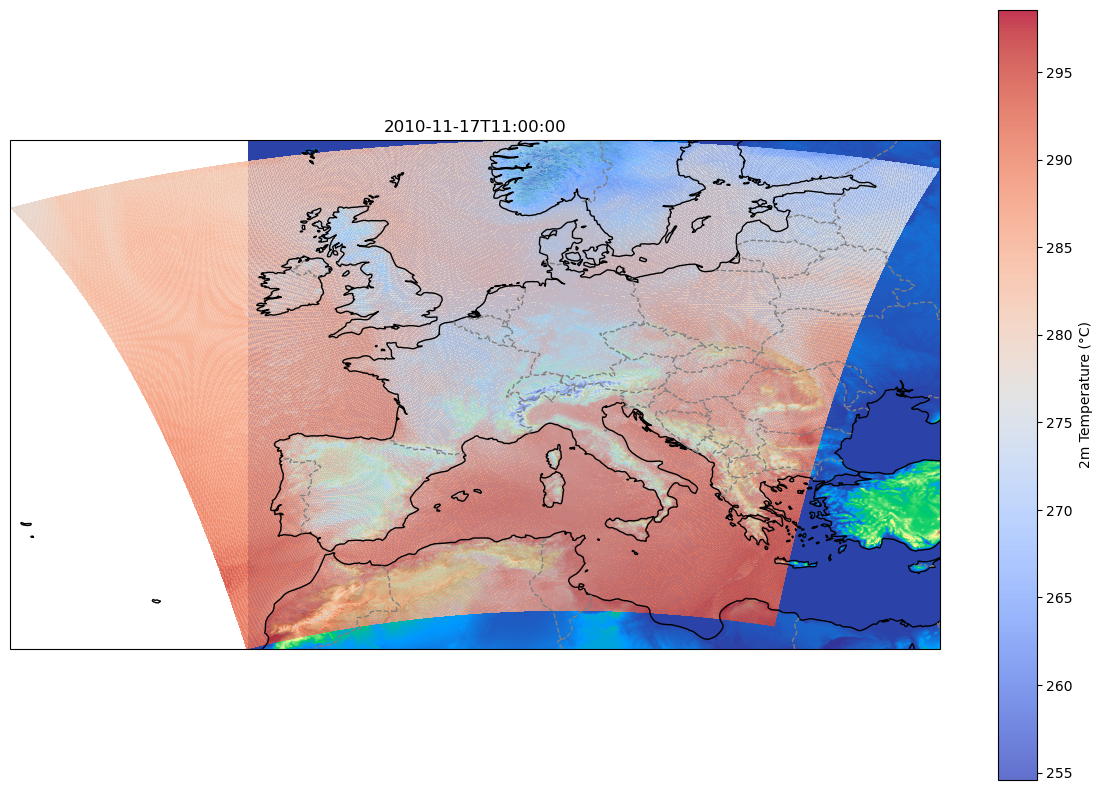

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio

T_2M = ds.T_2M.sel(time='2010-11-17T11:00:00')


proj=ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={"projection": proj})

dem_file = '/Users/fquareng/data/DEM/europe_dem_low_res.tif'

with rasterio.open(dem_file) as dem:
    dem_data = dem.read(1)  # Read the first band
    dem_extent = [dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top]
    
    # Plot the DEM using ax.imshow
    img = ax.imshow(
        dem_data,
        extent=dem_extent,
        transform=proj,
        cmap="terrain",
        origin="upper",
        alpha=1
    )

# Add coastlines and map features
ax.coastlines(resolution="50m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='gray')

plt.pcolormesh(ds.lon, ds.lat, T_2M, cmap='coolwarm', shading='auto', alpha=0.8)
plt.colorbar(label='2m Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('2010-11-17T11:00:00')
# Plot the DEM as an image


plt.show()

In [11]:
import rasterio
import numpy as np

def add_zero_columns_to_dem(input_file, output_file, min_longitude):
    """
    Adds columns of zero values to the left of a DEM file to match a given minimum longitude.
    
    Args:
    - input_file: Path to the input DEM file.
    - output_file: Path to the output DEM file.
    - min_longitude: The new minimum longitude for the DEM.
    """
    with rasterio.open(input_file) as src:
        dem_data = src.read(1)  # Read the first band
        transform = src.transform
        profile = src.profile.copy()
        
        # Extract existing geotransform parameters
        pixel_width = transform[0]
        current_min_lon = transform[2]

        # Calculate the number of columns to add
        lon_diff = current_min_lon - min_longitude
        print(lon_diff)
        if lon_diff <= 0:
            raise ValueError("The specified minimum longitude is greater than or equal to the current minimum longitude.")
        num_new_cols = int(np.ceil(lon_diff / pixel_width))
        print(num_new_cols)
        
        # Add zero columns
        new_cols = np.zeros((dem_data.shape[0], num_new_cols), dtype=dem_data.dtype)
        extended_dem_data = np.hstack((new_cols, dem_data))
        print(extended_dem_data.shape[1])
        
        # # Update the transform for the new minimum longitude
        new_transform = rasterio.Affine(
            pixel_width, 0, min_longitude,  # X: pixel size, rotation (0), new top-left longitude
            0, transform[4], transform[5]  # Y: rotation (0), pixel size, existing top-left latitude
        )
        
        # Update profile
        profile.update({
            "width": extended_dem_data.shape[1],
            "transform": new_transform,
            "dtype": dem_data.dtype
        })
        
        # Save the updated DEM
        with rasterio.open(output_file, "w", **profile) as dst:
            dst.write(extended_dem_data, 1)

# Example usage
input_dem = '/Users/fquareng/data/DEM/europe_dem_low_res.tif'
output_dem = "/Users/fquareng/data/DEM/europe_dem_low_res_adjusted_dem_with_zeros.tif"
min_longitude = -26.539766  # Set desired minimum longitude
add_zero_columns_to_dem(input_dem, output_dem, min_longitude)

15.539349300000012
529
2071


[-26.539766, 34.35909478685691, 29.607083366666657, 62.960416699999996]


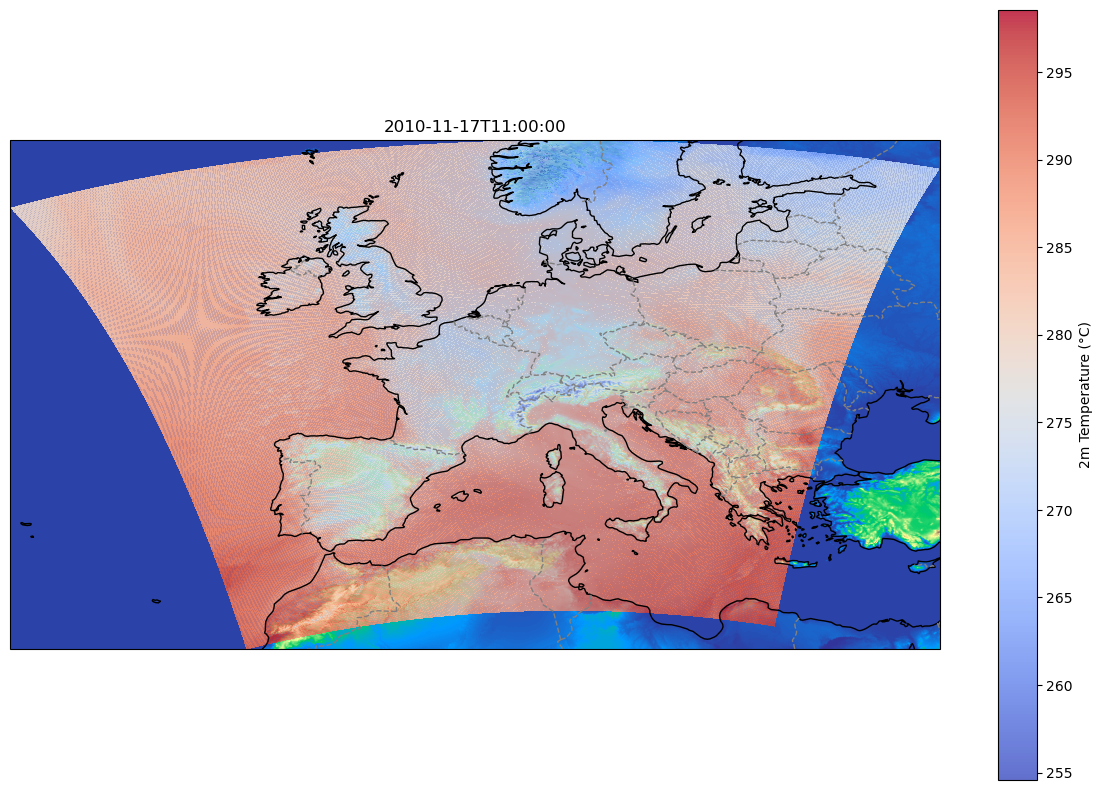

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio

T_2M = ds.T_2M.sel(time='2010-11-17T11:00:00')


proj=ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={"projection": proj})

dem_file = "/Users/fquareng/data/DEM/europe_dem_low_res_adjusted_dem_with_zeros.tif"

with rasterio.open(dem_file) as dem:
    dem_data = dem.read(1)  # Read the first band
    dem_extent = [dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top]
    print(dem_extent)
    # Plot the DEM using ax.imshow
    img = ax.imshow(
        dem_data,
        extent=dem_extent,
        #transform=proj,
        cmap="terrain",
        #origin="upper",
        alpha=1
    )

# # Add coastlines and map features
ax.coastlines(resolution="50m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='gray')

plt.pcolormesh(ds.lon, ds.lat, T_2M, cmap='coolwarm', shading='auto', alpha=0.8)
plt.colorbar(label='2m Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('2010-11-17T11:00:00')

plt.show()

# Dataloader

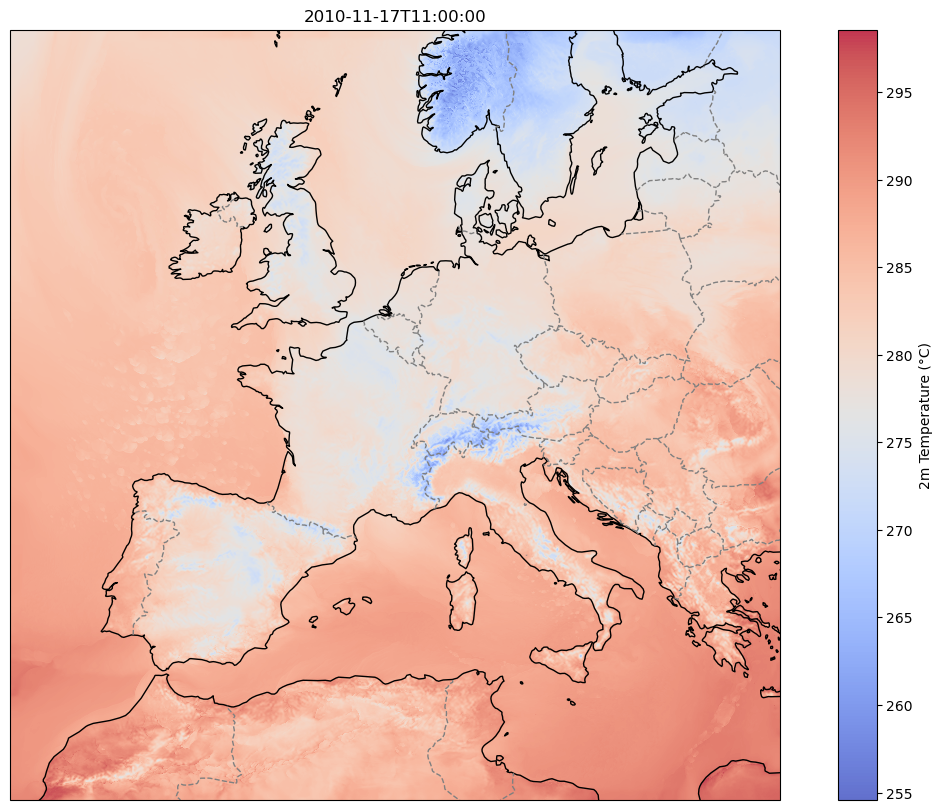

In [34]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio

T_2M = ds.T_2M.sel(time='2010-11-17T11:00:00')

pole_lat = 43.0
pole_lon = -170.0
rotated_crs = ccrs.RotatedPole(pole_latitude=pole_lat, pole_longitude=pole_lon)

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={"projection": rotated_crs})

# # Add coastlines and map features
ax.coastlines(resolution="50m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='gray')

plt.pcolormesh(ds.rlon, ds.rlat, T_2M, cmap='coolwarm', shading='auto', alpha=0.8)
plt.colorbar(label='2m Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('2010-11-17T11:00:00')

plt.show()

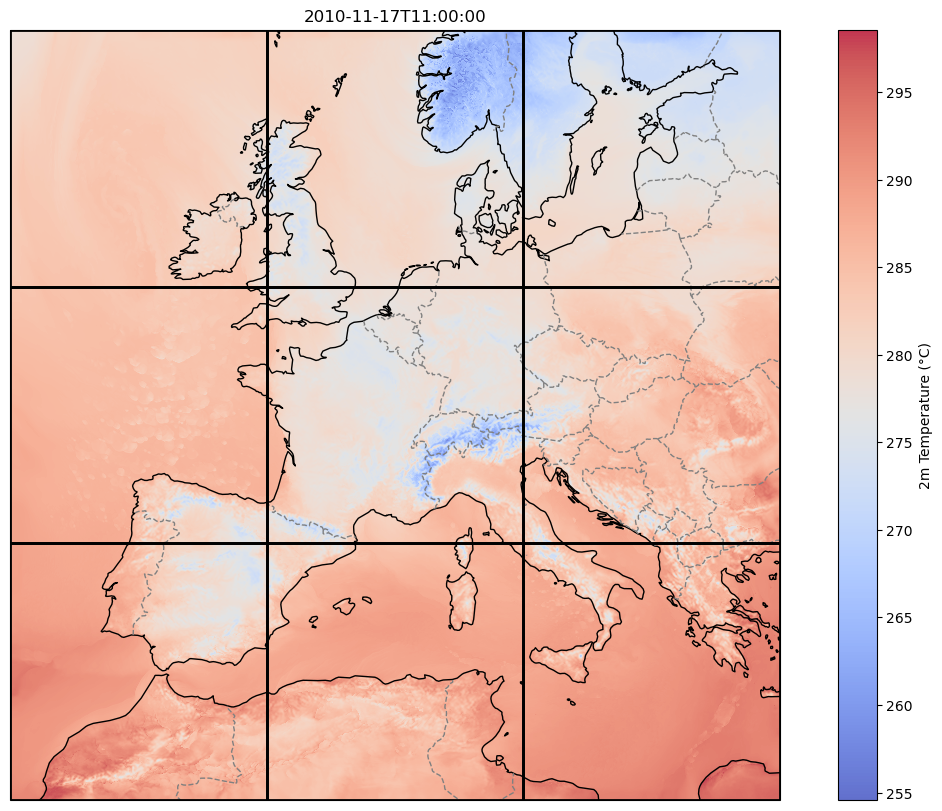

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import rasterio

# Assuming ds is already loaded and contains the relevant T_2M data
# For the sake of this example, we'll assume the data is loaded correctly
T_2M = ds.T_2M.sel(time='2010-11-17T11:00:00')

pole_lat = 43.0
pole_lon = -170.0
rotated_crs = ccrs.RotatedPole(pole_latitude=pole_lat, pole_longitude=pole_lon)

# Create the plot with the rotated projection
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={"projection": rotated_crs})

# Add coastlines and map features
ax.coastlines(resolution="50m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='gray')

# Plot the temperature data
plt.pcolormesh(ds.rlon, ds.rlat, T_2M, cmap='coolwarm', shading='auto', alpha=0.8)
plt.colorbar(label='2m Temperature (°C)')

# Define grid properties (3x3 grid without padding)
num_rows = 3
num_cols = 3

# Get the extent of the grid (this will depend on the dimensions of your data)
lon_min, lon_max = ds.rlon.min(), ds.rlon.max()
lat_min, lat_max = ds.rlat.min(), ds.rlat.max()

# Calculate the width and height of each square grid cell
grid_width = (lon_max - lon_min) / num_cols
grid_height = (lat_max - lat_min) / num_rows

# Create the grid (3x3) without padding
for i in range(num_cols):
    for j in range(num_rows):
        # Calculate the position of the lower-left corner of each square
        lon_start = lon_min + i * grid_width
        lon_end = lon_start + grid_width
        lat_start = lat_min + j * grid_height
        lat_end = lat_start + grid_height
        
        # Plot the grid squares
        ax.plot([lon_start, lon_start, lon_end, lon_end, lon_start], 
                [lat_start, lat_end, lat_end, lat_start, lat_start], 
                color='black', linewidth=2)

# Add labels for longitude and latitude
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Set title
plt.title('2010-11-17T11:00:00')

# Show the plot
plt.show()

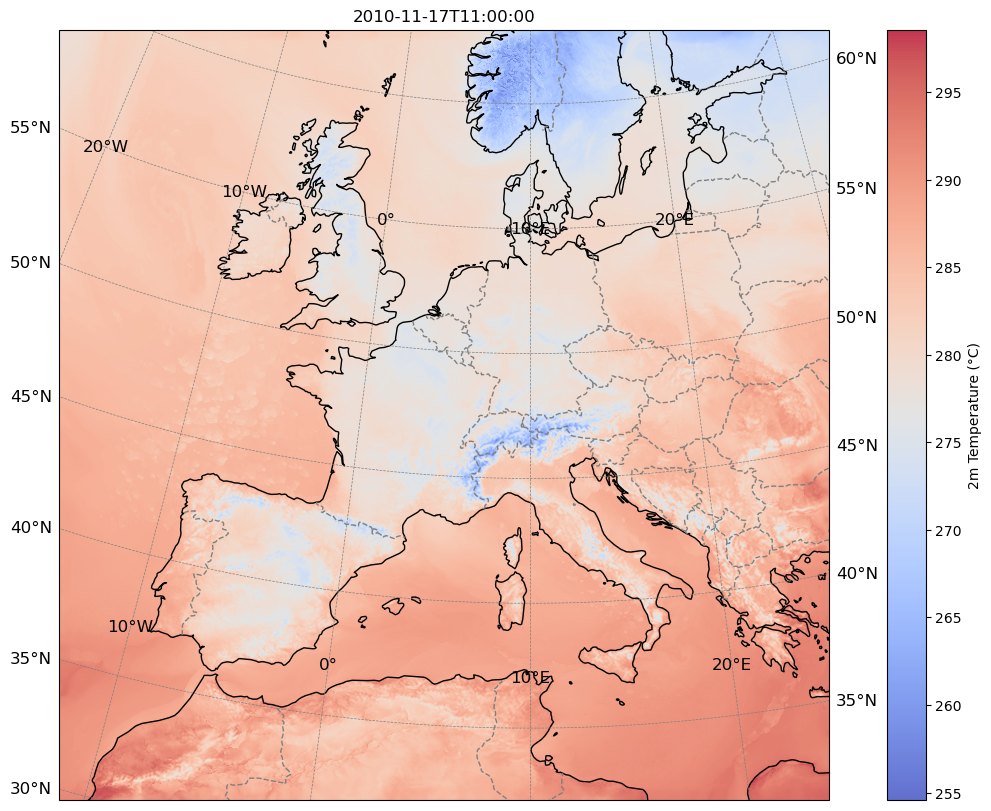

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming you already have your dataset 'ds' loaded and T_2M selected.
T_2M = ds.T_2M.sel(time='2010-11-17T11:00:00')  # Example of how you might select the temperature data.

pole_lat = 43.0
pole_lon = -170.0
rotated_crs = ccrs.RotatedPole(pole_latitude=pole_lat, pole_longitude=pole_lon)

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={"projection": rotated_crs})

# Add coastlines and map features
ax.coastlines(resolution="50m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='gray')

# Plot your temperature data (example, assuming ds.rlon and ds.rlat are your longitudes and latitudes)
plt.pcolormesh(ds.rlon, ds.rlat, T_2M, cmap='coolwarm', shading='auto', alpha=0.8)

# Here, replace `ds.rlon`, `ds.rlat`, and `T_2M` with your actual data variables
# Example: for demonstration, we use some dummy data:
# import numpy as np
# lon = np.linspace(-180, 180, 360)
# lat = np.linspace(-90, 90, 180)
# lon_grid, lat_grid = np.meshgrid(ds.lon, ds.lat)
# T_2M = np.sin(np.radians(lat_grid)) * np.cos(np.radians(lon_grid))  # Example temperature data

# plt.pcolormesh(lon_grid, lat_grid, T_2M, cmap='coolwarm', shading='auto', alpha=0.8)

# Add colorbar
plt.colorbar(label='2m Temperature (°C)')

# Add gridlines
gl = ax.gridlines(draw_labels=True, color='gray', linestyle='--', linewidth=0.5)

# Set gridline labels format (adjust as necessary for the rotated projection)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}

# Add axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('2010-11-17T11:00:00')

plt.show()

In [13]:
from osgeo import gdal, osr

input_dem = "/Users/fquareng/data/DEM/europe_dem_low_res.tif"
output_dem = "/Users/fquareng/data/DEM/europe_dem_low_res_reprojected.tif"


# Define the target projection using Proj4 string for a rotated pole
proj4_rotated_pole = "+proj=ob_tran +o_proj=longlat +o_lon_p=-170 +o_lat_p=43 +datum=WGS84"

# Create an empty SpatialReference object
target_srs = osr.SpatialReference()
target_srs.ImportFromProj4(proj4_rotated_pole)  # Import the rotated pole CRS from Proj4

# Open the input DEM file
src_ds = gdal.Open(input_dem)
if src_ds is None:
    raise ValueError("Could not open the input DEM file.")

# Set up the warp options
warp_options = gdal.WarpOptions(dstSRS=target_srs.ExportToWkt(), resampleAlg="bilinear")

# Reproject the DEM
gdal.Warp(destNameOrDestDS=output_dem, srcDSOrSrcDSTab=src_ds, options=warp_options)

print(f"Reprojected DEM saved to {output_dem}")

Reprojected DEM saved to /Users/fquareng/data/DEM/europe_dem_low_res_reprojected.tif


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1960, 'height': 1808, 'count': 1, 'crs': CRS.from_wkt('GEOGCRS["unnamed",BASEGEOGCRS["unknown",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ID["EPSG",6326]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],DERIVINGCONVERSION["unknown",METHOD["PROJ ob_tran o_proj=longlat"],PARAMETER["o_lon_p",-170,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["o_lat_p",43,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]],CS[ellipsoidal,2],AXIS["longitude",east,ORDER[1],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],AXIS["latitude",north,ORDER[2],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]]'), 'transform': Affine(0.02036986381954627, 0.0, -179.97397820969286,
       0.0, -0.02036986381954627, 19.446836377321414)}


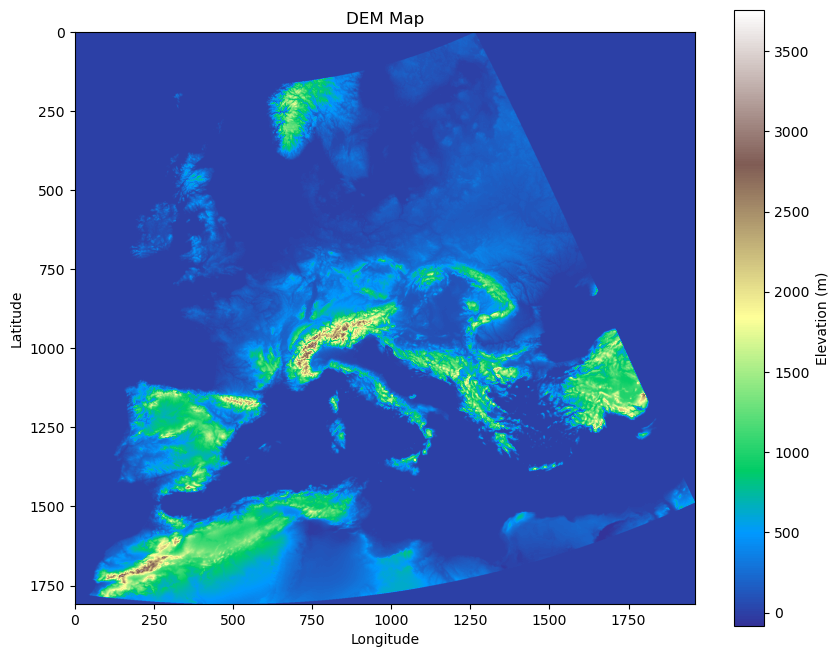

In [16]:

# Open the .tiff file using rasterio
dem_file = '/Users/fquareng/data/DEM/reprojected_dem.tif'
with rasterio.open(dem_file) as src:
    # Read the DEM data
    dem_data = src.read(1)  # Read the first band (assuming the DEM is single-band)

    # Get the metadata for the .tiff
    meta = src.meta
    print(meta)

# Plot the DEM data
plt.figure(figsize=(10, 8))
plt.imshow(dem_data, cmap='terrain')#, origin='upper')  # 'terrain' colormap for elevation
plt.colorbar(label='Elevation (m)')
plt.title('DEM Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

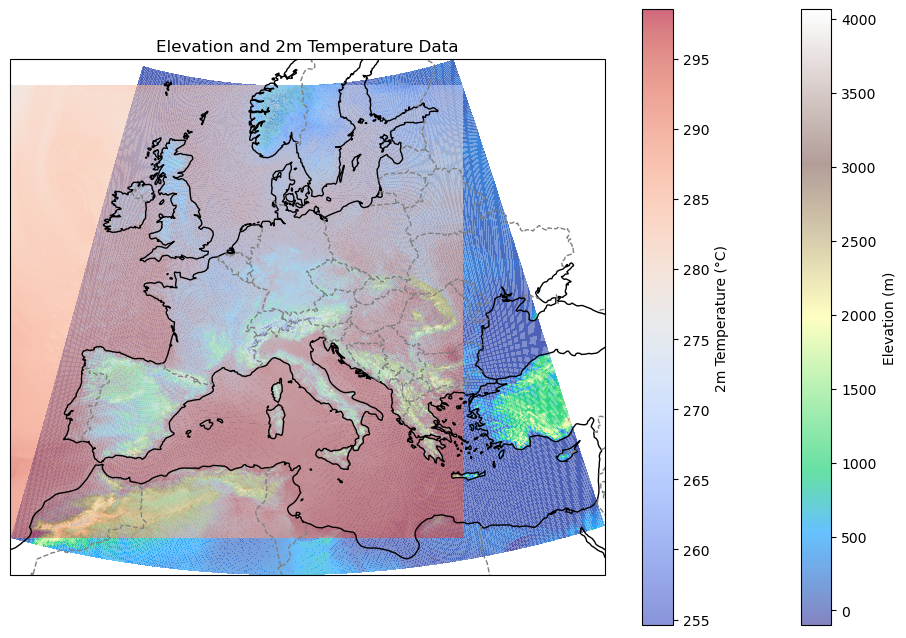

In [24]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# File paths
# dem_file = "/Users/fquareng/data/DEM/reprojected_dem.tif"  # Path to your reprojected DEM file
dem_file = "/Users/fquareng/data/DEM/europe_dem_low_res.tif"  # Path to your reprojected DEM file
temperature_data = ds.T_2M.sel(time="2010-11-17T11:00:00")  # Your temperature dataset

# Rotated pole parameters
pole_lat = 43.0
pole_lon = -170.0
rotated_crs = ccrs.RotatedPole(pole_latitude=pole_lat, pole_longitude=pole_lon)

# Load the DEM file
with rasterio.open(dem_file) as dem:
    dem_data = dem.read(1)  # Read the first band
    dem_transform = dem.transform  # Get the affine transform
    dem_crs = dem.crs  # CRS of the DEM file
    dem_nodata = dem.nodata  # NoData value (if any)
    dem_extent = (
        dem.bounds.left,
        dem.bounds.right,
        dem.bounds.bottom,
        dem.bounds.top,
    )

# Mask NoData values in DEM
if dem_nodata is not None:
    dem_data = np.where(dem_data == dem_nodata, np.nan, dem_data)

# Get grid for DEM
dem_x = np.arange(dem_extent[0], dem_extent[1], dem_transform[0])
dem_y = np.arange(dem_extent[3], dem_extent[2], dem_transform[4])  # Reversed for raster
# Prepare temperature grid (rlon and rlat)
temp_lon, temp_lat = np.meshgrid(ds.rlon, ds.rlat)
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": rotated_crs})

# Add DEM data
dem_img = ax.pcolormesh(
    dem_x,
    dem_y,
    dem_data,
    cmap="terrain",
    transform=ccrs.PlateCarree(),
    alpha=0.6,
    shading="auto",
)
plt.colorbar(dem_img, ax=ax, orientation="vertical", label="Elevation (m)")

# Add temperature data
temp_img = ax.pcolormesh(
    temp_lon,
    temp_lat,
    temperature_data,
    cmap="coolwarm",
    transform=rotated_crs,
    alpha=0.6,
    shading="auto",
)
plt.colorbar(temp_img, ax=ax, orientation="vertical", label="2m Temperature (°C)")

# Add map features
ax.coastlines(resolution="50m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="gray")

# Title and labels
ax.set_title("Elevation and 2m Temperature Data")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

# Old code with wrong altitude - temperature association

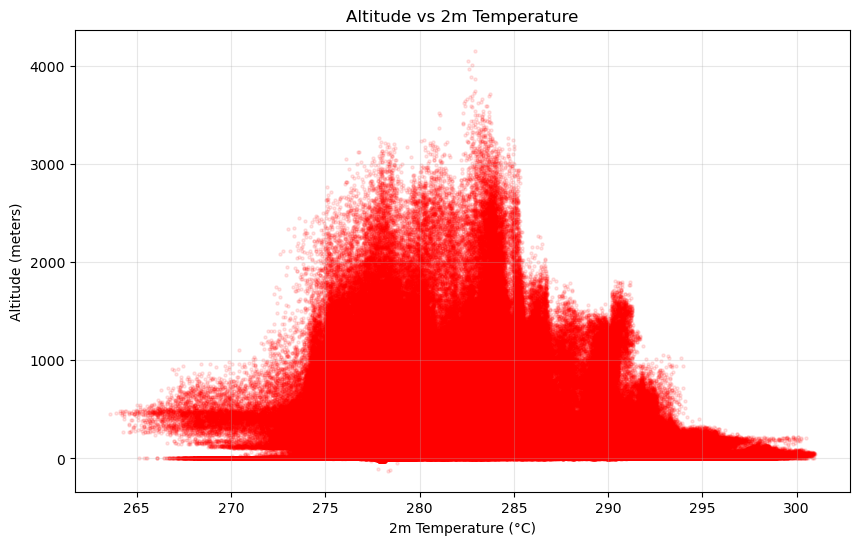

In [66]:
def plot_altitude_vs_temperature(dem_file, temp_file, variable="T_2M", time_step=0):
    # Load DEM data
    with rasterio.open(dem_file) as dem_src:
        altitude = dem_src.read(1)  # Read the first (and usually only) band
        dem_transform = dem_src.transform

    # Load temperature data
    temp_ds = xr.open_dataset(temp_file)
    temperature = temp_ds[variable].isel(time=time_step).values  # Select the first time step

    # Check dimensions match
    if altitude.shape != temperature.shape:
        raise ValueError("Altitude and temperature dimensions do not match. Check input files.")

    # Flatten the 2D grid into 1D arrays
    altitude_flat = altitude.flatten()
    temperature_flat = temperature.flatten()

    # Remove NaN values (common in geospatial data)
    valid_mask = ~np.isnan(altitude_flat) & ~np.isnan(temperature_flat)
    altitude_flat = altitude_flat[valid_mask]
    temperature_flat = temperature_flat[valid_mask]

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(temperature_flat, altitude_flat, s=5, alpha=0.1, c="red")
    plt.title("Altitude vs 2m Temperature")
    plt.ylabel("Altitude (meters)")
    plt.xlabel("2m Temperature (°C)")
    plt.grid(alpha=0.3)
    plt.show()

# Example usage
dem_file = '/Users/fquareng/data/europe_dem_low_res.tif'
temp_file = '/Users/fquareng/data/T_2M.nc'
plot_altitude_vs_temperature(dem_file, temp_file)

| 0.03, 0.00,-11.00|
| 0.00,-0.02, 61.10|
| 0.00, 0.00, 1.00|
Number of points with altitude > 100 meters: 1001408
Number of points with altitude ≤ 100 meters: 1376356


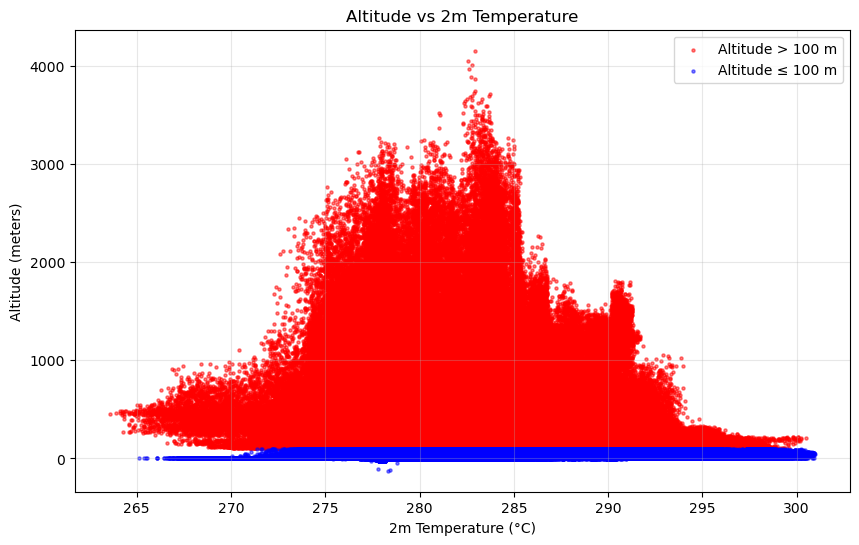

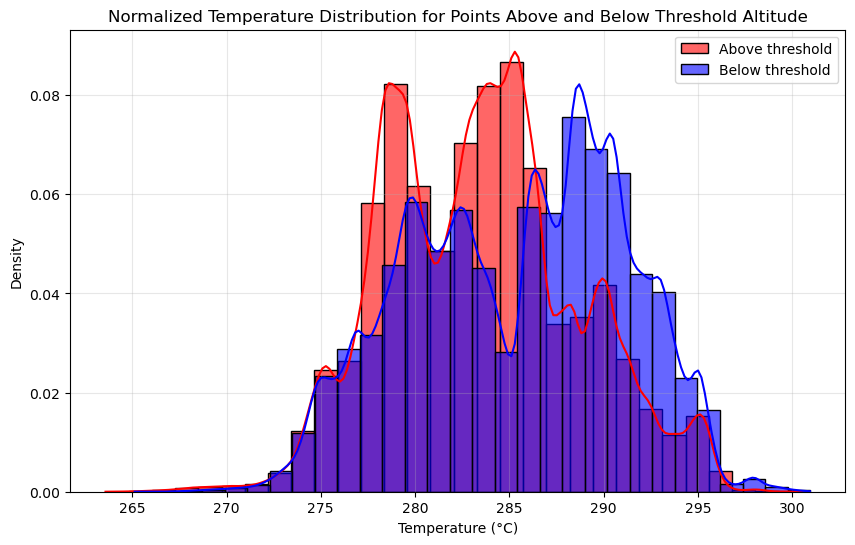

| 0.03, 0.00,-11.00|
| 0.00,-0.02, 61.10|
| 0.00, 0.00, 1.00|
Number of points with altitude > 800 meters: 185647
Number of points with altitude ≤ 800 meters: 2192117


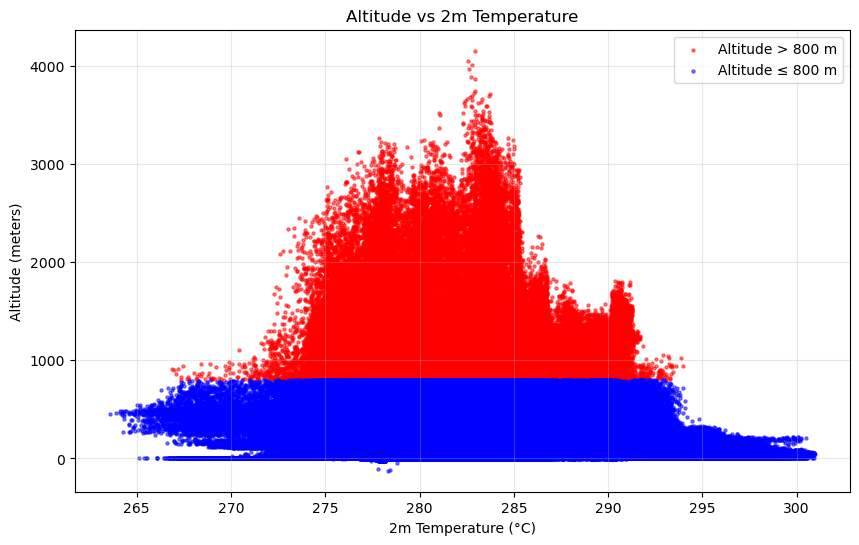

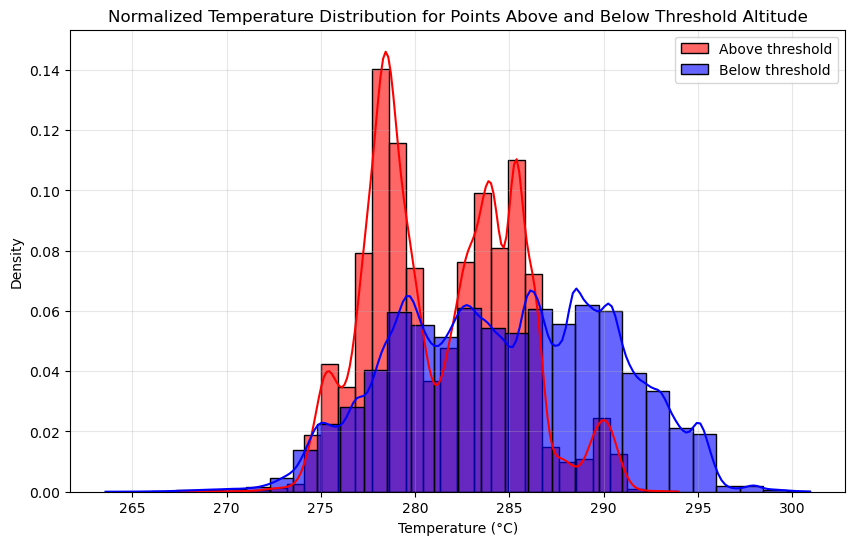

| 0.03, 0.00,-11.00|
| 0.00,-0.02, 61.10|
| 0.00, 0.00, 1.00|
Number of points with altitude > 2000 meters: 10528
Number of points with altitude ≤ 2000 meters: 2367236


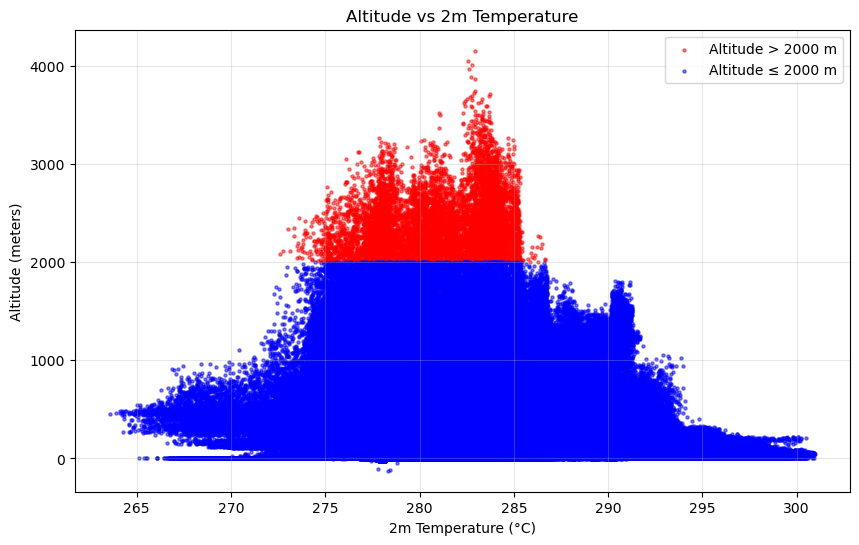

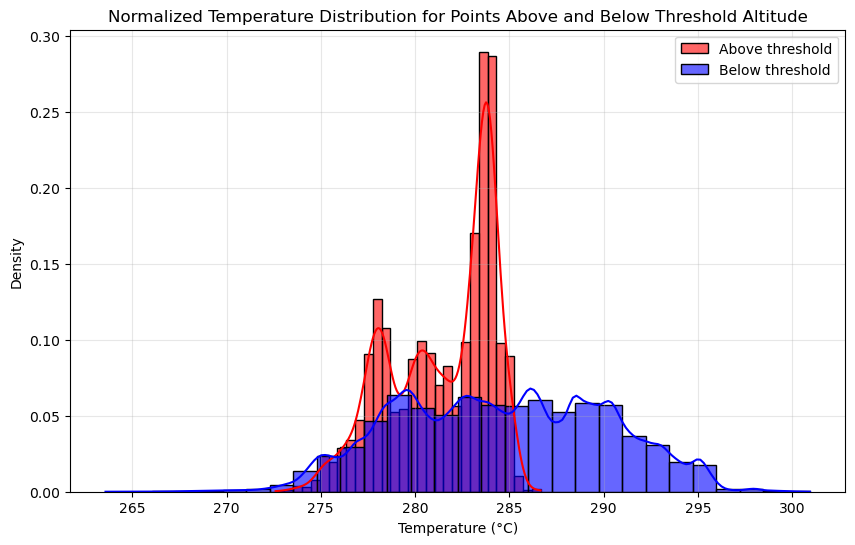

| 0.03, 0.00,-11.00|
| 0.00,-0.02, 61.10|
| 0.00, 0.00, 1.00|
Number of points with altitude > 3000 meters: 390
Number of points with altitude ≤ 3000 meters: 2377374


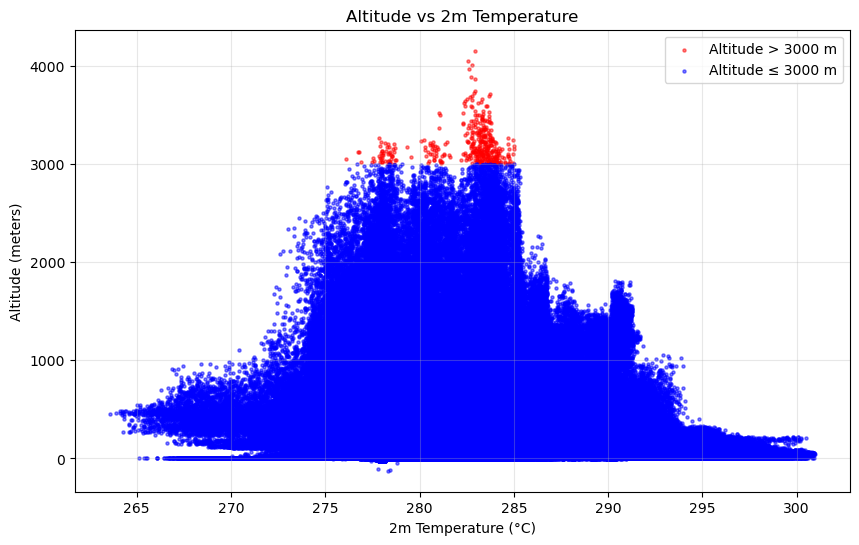

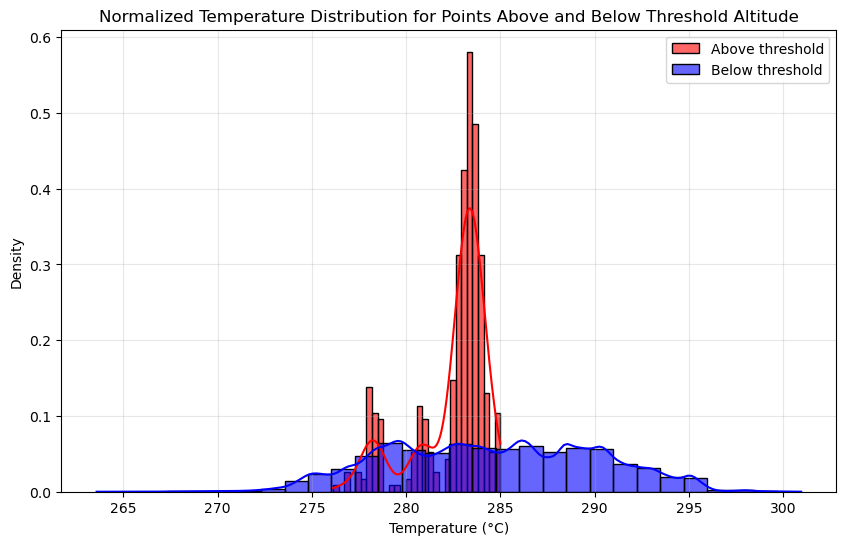

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import xarray as xr
import seaborn as sns

def plot_altitude_vs_temperature(dem_file, temp_file, variable="T_2M", time_step=0, threshold=1000):
    # Load DEM data
    with rasterio.open(dem_file) as dem_src:
        altitude = dem_src.read(1)  # Read the first (and usually only) band
        dem_transform = dem_src.transform

    # Load temperature data
    temp_ds = xr.open_dataset(temp_file)
    temperature = temp_ds[variable].isel(time=time_step).values  # Select the first time step

    # Check dimensions match
    if altitude.shape != temperature.shape:
        raise ValueError("Altitude and temperature dimensions do not match. Check input files.")

    # Flatten the 2D grid into 1D arrays
    altitude_flat = altitude.flatten()
    temperature_flat = temperature.flatten()

    # Remove NaN values (common in geospatial data)
    valid_mask = ~np.isnan(altitude_flat) & ~np.isnan(temperature_flat)
    altitude_flat = altitude_flat[valid_mask]
    temperature_flat = temperature_flat[valid_mask]

    # Create a mask for altitude > threshold
    mask_above_threshold = altitude_flat > threshold

    # Count the number of points above and below the threshold
    num_above_threshold = np.sum(mask_above_threshold)
    num_below_threshold = np.sum(~mask_above_threshold)

    # Print the counts
    print(f"Number of points with altitude > {threshold} meters: {num_above_threshold}")
    print(f"Number of points with altitude ≤ {threshold} meters: {num_below_threshold}")

    # Scatter plot with two colors based on altitude
    plt.figure(figsize=(10, 6))
    
    # Plot points where altitude is above the threshold in one color
    plt.scatter(temperature_flat[mask_above_threshold], altitude_flat[mask_above_threshold], 
                s=5, alpha=0.5, c='red', label=f'Altitude > {threshold} m')
    
    # Plot points where altitude is below or equal to the threshold in another color
    plt.scatter(temperature_flat[~mask_above_threshold], altitude_flat[~mask_above_threshold], 
                s=5, alpha=0.5, c='blue', label=f'Altitude ≤ {threshold} m')

    plt.title("Altitude vs 2m Temperature")
    plt.ylabel("Altitude (meters)")
    plt.xlabel("2m Temperature (°C)")
    plt.grid(alpha=0.3)

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

    # Call the function to plot the normalized temperature distribution for points above and below the threshold
    plot_normalized_temperature_distribution(temperature_flat, mask_above_threshold)

def plot_normalized_temperature_distribution(temperature_flat, mask_above_threshold):
    # Filter temperature data for points above and below the threshold
    temperature_above_threshold = temperature_flat[mask_above_threshold]
    temperature_below_threshold = temperature_flat[~mask_above_threshold]

    # Plot distribution (Histogram) with normalized frequency
    plt.figure(figsize=(10, 6))
    
    # Plot the normalized distribution for points above the threshold in red
    sns.histplot(temperature_above_threshold, kde=True, bins=30, color='red', label="Above threshold", stat='density', alpha=0.6)

    # Plot the normalized distribution for points below the threshold in blue
    sns.histplot(temperature_below_threshold, kde=True, bins=30, color='blue', label="Below threshold", stat='density', alpha=0.6)

    plt.title("Normalized Temperature Distribution for Points Above and Below Threshold Altitude")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Density")
    plt.grid(alpha=0.3)

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

# Example usage
dem_file = '/Users/fquareng/data/europe_dem_low_res.tif'
temp_file = '/Users/fquareng/data/T_2M.nc'
plot_altitude_vs_temperature(dem_file, temp_file, threshold=100)
plot_altitude_vs_temperature(dem_file, temp_file, threshold=800)
plot_altitude_vs_temperature(dem_file, temp_file, threshold=2000)
plot_altitude_vs_temperature(dem_file, temp_file, threshold=3000)

In [143]:
import numpy as np
import rasterio
import xarray as xr
import matplotlib.pyplot as plt
from affine import Affine

def select_points_above_altitude(dem_file, temp_file, variable="T_2M", time_step=0, altitude_threshold=1000):
    # Load DEM data
    with rasterio.open(dem_file) as dem_src:
        altitude = dem_src.read(1)  # Read the first (and usually only) band
        dem_transform = dem_src.transform

    # Load temperature data
    temp_ds = xr.open_dataset(temp_file)
    temperature = temp_ds[variable].isel(time=time_step)  # Select the specified time step

    # Check dimensions match
    if altitude.shape != temperature.shape:
        raise ValueError("Altitude and temperature dimensions do not match. Check input files.")

    # Create latitude and longitude arrays from the DEM's affine transform
    rows, cols = np.meshgrid(np.arange(altitude.shape[0]), np.arange(altitude.shape[1]), indexing='ij')
    lon, lat = rasterio.transform.xy(dem_transform, rows, cols)

    # Convert to 2D arrays
    lon = np.array(lon)
    lat = np.array(lat)

    # Flatten the 2D arrays into 1D arrays
    altitude_flat = altitude.flatten()
    temperature_flat = temperature.values.flatten()
    lon_flat = lon.flatten()
    lat_flat = lat.flatten()

    # Remove NaN values (common in geospatial data)
    valid_mask = ~np.isnan(altitude_flat) & ~np.isnan(temperature_flat)
    altitude_flat = altitude_flat[valid_mask]
    temperature_flat = temperature_flat[valid_mask]
    lon_flat = lon_flat[valid_mask]
    lat_flat = lat_flat[valid_mask]

    # Select points above the altitude threshold
    high_altitude_mask = altitude_flat > altitude_threshold
    selected_altitude = altitude_flat[high_altitude_mask]
    selected_temperature = temperature_flat[high_altitude_mask]
    selected_lon = lon_flat[high_altitude_mask]
    selected_lat = lat_flat[high_altitude_mask]

    # Create a new dataset with the selected points
    selected_data = {
        "altitude": selected_altitude,
        "temperature": selected_temperature,
        "longitude": selected_lon,
        "latitude": selected_lat,
    }

    # Optional: Return the data as an xarray Dataset
    selected_ds = xr.Dataset(
        {
            "temperature": (["points"], selected_temperature),
            "altitude": (["points"], selected_altitude),
        },
        coords={
            "longitude": (["points"], selected_lon),
            "latitude": (["points"], selected_lat),
        },
    )

    return selected_ds

# Example usage
dem_file = '/Users/fquareng/data/europe_dem_low_res.tif'
temp_file = '/Users/fquareng/data/T_2M.nc'
altitude_threshold = 1000  # Threshold in meters

selected_ds = select_points_above_altitude(dem_file, temp_file, altitude_threshold=altitude_threshold)
print(selected_ds)

<xarray.Dataset> Size: 3MB
Dimensions:      (points: 111433)
Coordinates:
    longitude    (points) float64 891kB 6.182 6.656 6.683 ... 3.812 3.839 3.865
    latitude     (points) float64 891kB 61.09 61.09 61.09 ... 34.35 34.35 34.35
Dimensions without coordinates: points
Data variables:
    temperature  (points) float32 446kB 289.6 289.9 289.9 ... 278.0 278.0 278.1
    altitude     (points) float32 446kB 1.042e+03 1.105e+03 ... 1.05e+03
